# Comparación de Clasificadores

## Comparación de los diferentes clasificadores con varios conjuntos de datos

A continuación se compararan los clasificadores: Naive Bayes, Perceptron, Regresión Logística, k-Vecinos más Cercanos, Árbol de Decisión, SVM Lineal, SVM Radial, Random Forrest y AdaBoost. Con diferentes conjunto de datos: Iris, vidrios, hongos, etc.

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Crear un diccionario Python con los clasificadores a utilizar

In [65]:
arbol = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clasificadores = {
    "Naive Bayes": GaussianNB(),
    "Perceptrón": Perceptron(max_iter=100, tol=1e-3),
    "Regresión Logística": LogisticRegression(),
    "k-Vecinos más Cercanos": KNeighborsClassifier(n_neighbors=5),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=5),
    "SVM Lineal": SVC(kernel='linear'),
    "SVM Radial": SVC(kernel='rbf', C=100, gamma=0.01),
    "Random Forrest": RandomForestClassifier(criterion='entropy',n_estimators=100),
    "AdaBoost": AdaBoostClassifier(base_estimator=arbol, n_estimators=500, learning_rate=0.1, random_state=1)
}

### Función para entrenar los diferentes clasificadores y calcular la exactitud de cada uno y el tiempo de ejecucion

In [66]:
numero_de_clasificadores = len(clasificadores.keys())

def compararClasificadores(X_entrenamiento, y_entrenamiento, X_prueba, y_prueba, verbose = True):
    resultados = pd.DataFrame(data=np.zeros(shape=(numero_de_clasificadores,4)), columns = ['Clasificador', 'Exactitud Entrenamiento', 'Exactitud Prueba', 'Tiempo Entrenamiento'])
    contador = 0
    for key, clasificador in clasificadores.items():
        tiempo_inicio = time.clock()
        clasificador.fit(X_entrenamiento, y_entrenamiento)
        tiempo_fin = time.clock()
        tiempo = tiempo_fin - tiempo_inicio
        exactitud_entrenamiento = clasificador.score(X_entrenamiento, y_entrenamiento)
        exactitud_prueba = clasificador.score(X_prueba, y_prueba)
        resultados.loc[contador, 'Clasificador'] = key
        resultados.loc[contador, 'Exactitud Entrenamiento'] = exactitud_entrenamiento
        resultados.loc[contador, 'Exactitud Prueba'] = exactitud_prueba
        resultados.loc[contador, 'Tiempo Entrenamiento'] = tiempo
        if verbose:
            print("{c} entrenado en {f:.2f} s".format(c=key, f=tiempo))
        contador+=1
    return resultados

### Función para graficar las regiones de decisión

In [67]:
from matplotlib.colors import ListedColormap


def graficar_regiones_decision(X, y, clasificador, indices_prueba=None, resolucion=0.02):

    # fijar los marcadores y el mapa de colores
    marcadores = ('o', 'x', 's', '^', 'v')
    colores = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    mapa_colores = ListedColormap(colores[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolucion),
                           np.arange(x2_min, x2_max, resolucion))
    Z = clasificador.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=mapa_colores)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # graficar los ejemplos de clases
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=mapa_colores(idx),
                    edgecolor='black',
                    marker=marcadores[idx], 
                    label=cl)
    
    # resaltar ejemplos de prueba
    if indices_prueba.any:
        X_test, y_test = X[indices_prueba, :], y[indices_prueba]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',
                alpha=1.0, linewidth=1, marker='o',
                s=55, label='test set')

### Función para imprimir la matriz de confusión

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(rc={"figure.figsize": (14, 8)})

def mostrar_matriz_confusion(X_prueba, y_prueba, columnas):
    i = 1
    for key, clasificador in clasificadores.items():
        plt.subplot(3,3,i)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.9)
        i += 1
        prediccion = clasificador.predict(X_prueba)
        skcm = confusion_matrix(y_prueba, prediccion)
        # colocar en un dataframe para imprimir las etiquetas
        skcm = pd.DataFrame(skcm, columns=columnas)
        skcm['actual'] = columnas
        skcm = skcm.set_index('actual')
        sns.heatmap(skcm, square=True, annot=True, cbar=False, fmt="d", cmap="Blues")
        plt.title(key)
        plt.xlabel('predicción')
        plt.ylabel('actual');
        

### Función para imprimir la curva ROC (Receiver Operating Characteristic)

La curva característica operativa del receptor (ROC) es una herramienta común utilizada con los clasificadores binarios. La curva ROC traza la tasa de verdaderos positivos (TVP) frente a la tasa de falsos positivos (TFP). La TFP es la proporción de instancias negativas que se clasifican incorrectamente como positivas. Es igual a uno menos la tasa de verdaderos negativos (TVN), que es la proporción de instancias negativas que se clasifican correctamente como negativas. El TVN también se llama especificidad. Por lo tanto, la curva ROC traza la sensibilidad (recuperación) versus (1 - especificidad). La precisión se mide por el área bajo la curva ROC. Un área de 1 representa una prueba perfecta; un área de .5 representa una prueba sin valor

<img src="figuras/curva-ROC.png" width="75%">

In [69]:
from sklearn.metrics import roc_curve, auc

def mostrar_roc(y_prueba, X_prueba):
    i = 1
    for key, clasificador in clasificadores.items():
        y_prediccion = clasificador.predict(X_prueba)
        tasa_falsos_positivos, tasa_verdaderos_positivos, umbral = roc_curve(y_prueba, y_prediccion)
        roc_auc = auc(tasa_falsos_positivos, tasa_verdaderos_positivos)
        plt.subplot(3,3,i)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
        i += 1
        plt.title(key)
        plt.plot(tasa_falsos_positivos,tasa_verdaderos_positivos, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('Tasa Verdaderos Positivos')
        plt.xlabel('Tasa Falsos Positivos')

### Cargar el conjunto de datos de vidrios

Conjunto de datos para identificar el tipo de vidrio definido en términos del contenido de óxido (Na, Fe, K, etc). Fuente [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)

In [70]:
vidrios = pd.read_csv('datos/glass.csv')
print(vidrios.shape)
display(vidrios.head())
display(vidrios.describe())

(214, 11)


,ID,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows_float_processed
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows_float_processed
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows_float_processed
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows_float_processed
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows_float_processed


,ID,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,54.250000,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


#### Eliminar columna ID

In [71]:
#del vidrios['ID']
vidrios.tail()

,ID,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Type
209,210,1.51623,14.14,0.0,2.88,72.61,0.08,9.18,1.06,0.0,headlamps
210,211,1.51685,14.92,0.0,1.99,73.06,0.00,8.40,1.59,0.0,headlamps
211,212,1.52065,14.36,0.0,2.02,73.42,0.00,8.44,1.64,0.0,headlamps
212,213,1.51651,14.38,0.0,1.94,73.61,0.00,8.48,1.57,0.0,headlamps
213,214,1.51711,14.23,0.0,2.08,73.36,0.00,8.62,1.67,0.0,headlamps


#### Codificar columna `Type` como números

In [72]:
le = LabelEncoder()
valores_unicos_columna = list(vidrios['Type'].unique())
ajustar_le = le.fit(valores_unicos_columna)
valores_columna = list(vidrios['Type'].values)
valores_columna_transformados = le.transform(valores_columna)
vidrios['Type'] = valores_columna_transformados
vidrios.head()

,ID,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


#### Crear conjuntos X1 con los atributos y y1 con la salida

In [73]:
columnas = vidrios.columns
X1 = vidrios[columnas]
del X1['Type']
y1 = vidrios['Type']

#### Crear los conjuntos de entrenamiento y prueba

In [74]:
X1_entrenamiento, X1_prueba, y1_entrenamiento, y1_prueba = train_test_split(X1, y1, stratify=y1, test_size=0.3, random_state=0)

#### Normalizar los datos. 
El normalizador se debe ajustar sobre el conjunto de entrenamiento solamente. Y se aplicará posteriormente a ambos conjuntos (entrenamiento y prueba)

In [75]:
sc = StandardScaler()
sc.fit(X1_entrenamiento)
X1_entrenamiento = sc.transform(X1_entrenamiento)
X1_prueba = sc.transform(X1_prueba)

#### Ejecutar la función `compararClasificadores` y deplegar los resultados

In [76]:
resultados1 = compararClasificadores(X1_entrenamiento, y1_entrenamiento, X1_prueba, y1_prueba)
display(resultados1.sort_values(by='Exactitud Prueba', ascending=False))

Naive Bayes entrenado en 0.01 s
Perceptrón entrenado en 0.00 s
Regresión Logística entrenado en 0.00 s
k-Vecinos más Cercanos entrenado en 0.00 s
Árbol de Decisión entrenado en 0.00 s
SVM Lineal entrenado en 0.00 s
SVM Radial entrenado en 0.00 s
Random Forrest entrenado en 0.20 s
AdaBoost entrenado en 0.01 s


,Clasificador,Exactitud Entrenamiento,Exactitud Prueba,Tiempo Entrenamiento
7,Random Forrest,1.000000,0.984615,0.202269
4,Árbol de Decisión,1.000000,0.969231,0.001215
8,AdaBoost,1.000000,0.969231,0.005334
6,SVM Radial,1.000000,0.953846,0.002140
5,SVM Lineal,0.973154,0.938462,0.002070
3,k-Vecinos más Cercanos,0.885906,0.892308,0.000999
2,Regresión Logística,0.845638,0.784615,0.003036
1,Perceptrón,0.758389,0.769231,0.002569
0,Naive Bayes,0.805369,0.707692,0.005650


In [77]:
print("Codificación de las Etiquetas:\n")
for i, item in enumerate(le.classes_):
    print(item, '-->', i)

Codificación de las Etiquetas:

building_windows_float_processed --> 0
building_windows_non_float_processed --> 1
containers --> 2
headlamps --> 3
tableware --> 4
vehicle_windows_float_processed --> 5


#### Mostrar la matriz de confusión:

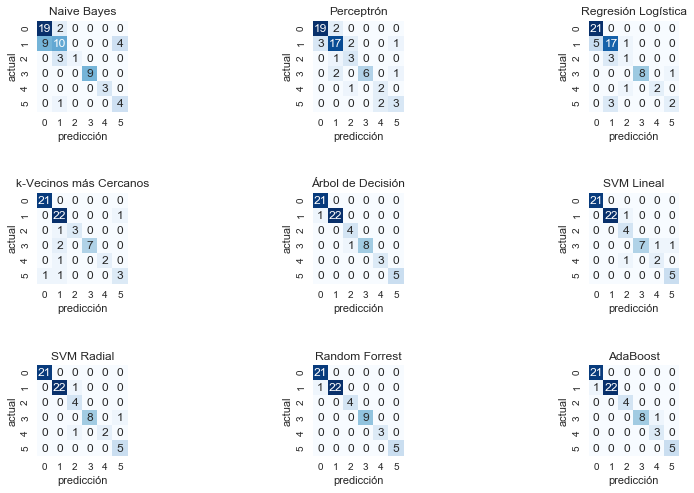

In [78]:
nombres = ['0', '1', '2', '3', '4', '5']
mostrar_matriz_confusion(X1_prueba, y1_prueba, columnas=nombres)

### Cargar el conjunto de datos Iris

In [79]:
iris = datasets.load_iris()
X2 = iris.data
y2 = iris.target

#### Crear conjuntos de entrenamiento y prueba

In [80]:
X2_entrenamiento, X2_prueba, y2_entrenamiento, y2_prueba = train_test_split(X2, y2, stratify=y2, test_size=0.3, random_state=0)

#### Normalizar los datos

In [81]:
sc.fit(X2_entrenamiento)
X2_entrenamiento = sc.transform(X2_entrenamiento)
X2_prueba = sc.transform(X2_prueba)

#### Ejecutar la función `compararClasificadores` y deplegar los resultados

In [82]:
resultados2 = compararClasificadores(X2_entrenamiento, y2_entrenamiento, X2_prueba, y2_prueba)
display(resultados2.sort_values(by='Exactitud Prueba', ascending=False))

Naive Bayes entrenado en 0.00 s
Perceptrón entrenado en 0.00 s
Regresión Logística entrenado en 0.00 s
k-Vecinos más Cercanos entrenado en 0.00 s
Árbol de Decisión entrenado en 0.00 s
SVM Lineal entrenado en 0.00 s
SVM Radial entrenado en 0.00 s
Random Forrest entrenado en 0.16 s
AdaBoost entrenado en 0.88 s


,Clasificador,Exactitud Entrenamiento,Exactitud Prueba,Tiempo Entrenamiento
5,SVM Lineal,0.980952,1.000000,0.001065
0,Naive Bayes,0.942857,0.977778,0.004369
3,k-Vecinos más Cercanos,0.961905,0.977778,0.000633
4,Árbol de Decisión,1.000000,0.977778,0.001149
6,SVM Radial,0.961905,0.977778,0.001140
7,Random Forrest,1.000000,0.977778,0.156934
8,AdaBoost,1.000000,0.977778,0.880889
2,Regresión Logística,0.933333,0.866667,0.001446
1,Perceptrón,0.800000,0.800000,0.002073


#### Mostrar la matriz de confusión:

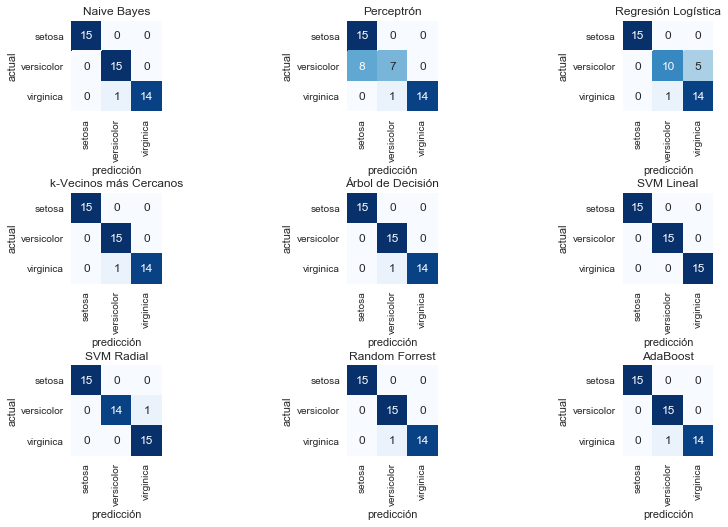

In [83]:
mostrar_matriz_confusion(X2_prueba, y2_prueba, columnas=['setosa','versicolor','virginica'])

### Cargar el conjunto de datos de hongos

Conjunto de datos de hongos descritos en términos de sus características físicas; clasificación: comestible o venenoso. Fuente [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Mushroom)

In [84]:
hongos = pd.read_csv('datos/mushroom.csv')
del hongos['veil-type']
print('Dimensiones: ', hongos.shape)
display(hongos.head())

Dimensiones:  (8124, 22)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


#### Convertir los datos categoricos a numericos

In [85]:
def label_encode(datos, columnas):
    for col in columnas:
        le = LabelEncoder()
        valores_unicos_columna = list(datos[col].unique())
        ajustar_le = le.fit(valores_unicos_columna)
 
        valores_columna = list(datos[col].values)
        valores_columna_transformados = le.transform(valores_columna)
        datos[col] = valores_columna_transformados

In [86]:
columnas_a_ser_codificadas = hongos.columns.values
label_encode(hongos, columnas_a_ser_codificadas)
display(hongos.head())

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


In [87]:
# colocar los atributos en  X (todos excepto la columna 0)
X3 = pd.DataFrame(hongos, columns=hongos.columns[1:len(hongos.columns)], index=hongos.index)
# colocar el valor de la clase (columna 0) en y
y3 = hongos['class']

#### Crear conjuntos de entrenamiento y prueba

In [88]:
X3_entrenamiento, X3_prueba, y3_entrenamiento, y3_prueba = train_test_split(X3, y3, stratify=y3, random_state=0)
print(y3_prueba.shape)

(2031,)


#### Ejecutar la función `compararClasificadores` y deplegar los resultados

In [89]:
resultados3 = resultados3 = compararClasificadores(X3_entrenamiento, y3_entrenamiento, X3_prueba, y3_prueba)
display(resultados3.sort_values(by='Exactitud Prueba', ascending=False))

Naive Bayes entrenado en 0.01 s
Perceptrón entrenado en 0.01 s
Regresión Logística entrenado en 0.25 s
k-Vecinos más Cercanos entrenado en 0.04 s
Árbol de Decisión entrenado en 0.01 s
SVM Lineal entrenado en 1.38 s
SVM Radial entrenado en 0.17 s
Random Forrest entrenado en 0.35 s
AdaBoost entrenado en 3.50 s


,Clasificador,Exactitud Entrenamiento,Exactitud Prueba,Tiempo Entrenamiento
6,SVM Radial,1.000000,1.000000,0.168360
7,Random Forrest,1.000000,1.000000,0.352119
8,AdaBoost,1.000000,1.000000,3.497208
3,k-Vecinos más Cercanos,0.999508,0.999508,0.037953
4,Árbol de Decisión,0.980141,0.976859,0.007253
5,SVM Lineal,0.960939,0.956672,1.378735
2,Regresión Logística,0.951256,0.944855,0.253889
1,Perceptrón,0.946168,0.941901,0.005082
0,Naive Bayes,0.919416,0.918267,0.007535


#### Mostrar la matriz de confusión:

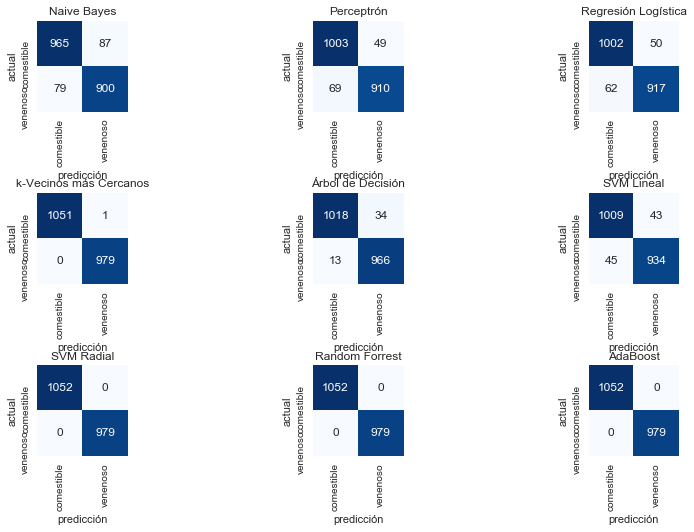

In [90]:
mostrar_matriz_confusion(X3_prueba, y3_prueba, columnas=['comestible','venenoso'])

#### Mostrar curva ROC:

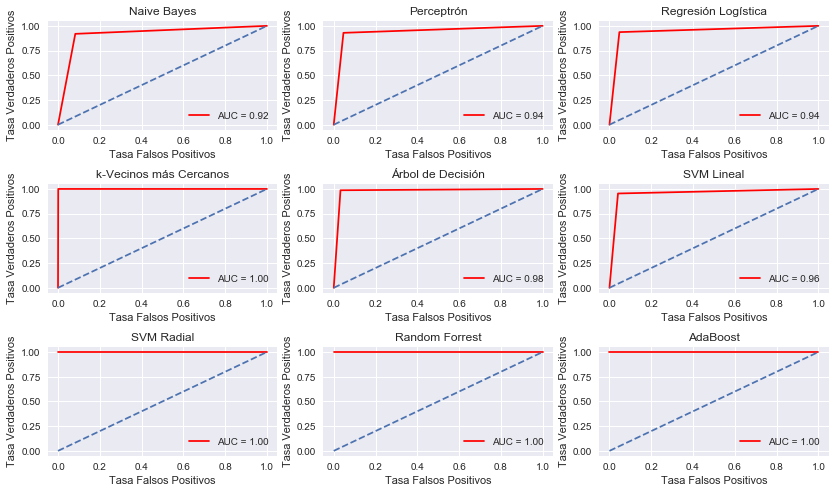

In [91]:
mostrar_roc(y3_prueba, X3_prueba)

### Generar un conjunto de datos usando la función `make_moons` de sklearn

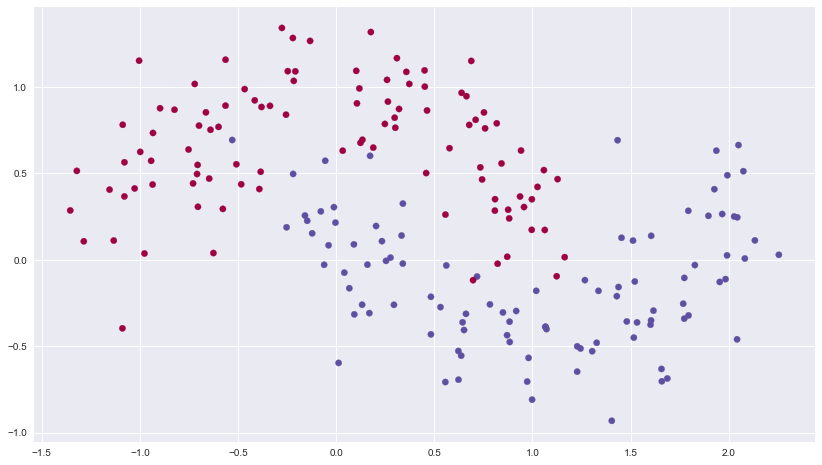

In [92]:
# Generar el conjunt de datos y graficarlo
np.random.seed(0)
X, y = datasets.make_moons(200, noise=0.2)
plt.scatter(X[:,0],  X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
# Convertir X e y en pandas DataFrame
X4 = pd.DataFrame(X)
y4 = pd.DataFrame(y)

Crear conjuntos de entrenamiento y prueba

In [93]:
X4_entrenamiento, X4_prueba, y4_entrenamiento, y4_prueba = train_test_split(X4, y4, random_state=0)

Ejecutar la función `compararClasificadores` y deplegar los resultados

In [94]:
resultados4 = compararClasificadores(X4_entrenamiento, y4_entrenamiento, X4_prueba, y4_prueba)
display(resultados4.sort_values(by='Exactitud Prueba', ascending=False))

/Users/wladimir/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wladimir/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/wladimir/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Naive Bayes entrenado en 0.01 s
Perceptrón entrenado en 0.00 s
Regresión Logística entrenado en 0.00 s
k-Vecinos más Cercanos entrenado en 0.00 s
Árbol de Decisión entrenado en 0.00 s
SVM Lineal entrenado en 0.00 s
SVM Radial entrenado en 0.00 s
Random Forrest entrenado en 0.18 s


/Users/wladimir/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost entrenado en 0.92 s


,Clasificador,Exactitud Entrenamiento,Exactitud Prueba,Tiempo Entrenamiento
3,k-Vecinos más Cercanos,0.953333,1.00,0.000942
8,AdaBoost,1.000000,1.00,0.924009
7,Random Forrest,1.000000,0.98,0.181816
4,Árbol de Decisión,0.966667,0.96,0.001306
0,Naive Bayes,0.840000,0.84,0.005135
2,Regresión Logística,0.840000,0.84,0.001430
5,SVM Lineal,0.846667,0.84,0.001351
6,SVM Radial,0.853333,0.84,0.001401
1,Perceptrón,0.706667,0.68,0.001414


Mostrar la matriz de confusión:

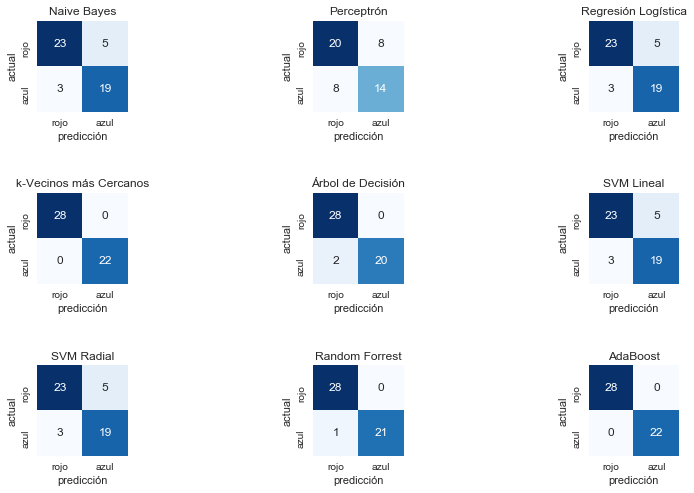

In [95]:
mostrar_matriz_confusion(X4_prueba, y4_prueba, columnas=['rojo','azul'])

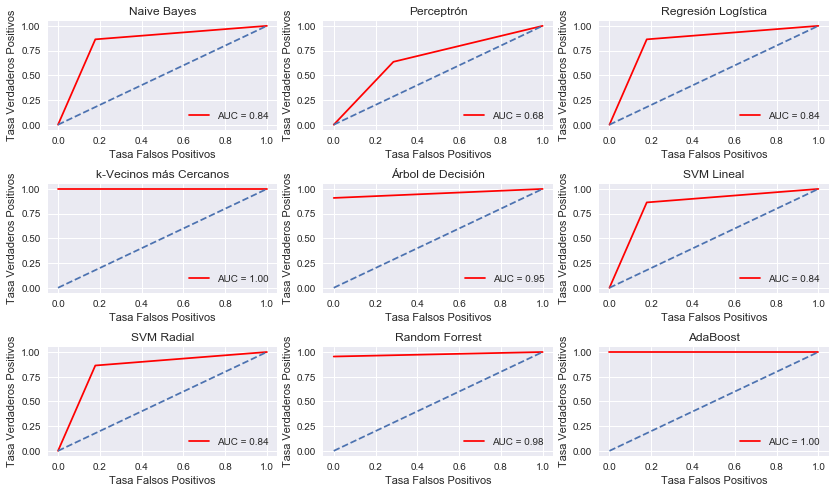

In [96]:
mostrar_roc(y4_prueba, X4_prueba)

### Graficar la regiones de decisión para el clasificador k-Vecinos más cercanos.

In [97]:
indices = np.array(y4_prueba.index)

/Users/wladimir/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


1.0
1.0
1.0
1.0
1.0


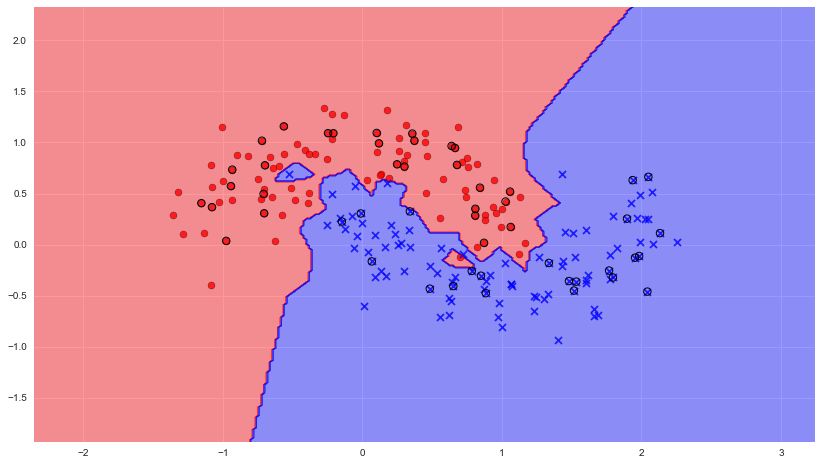

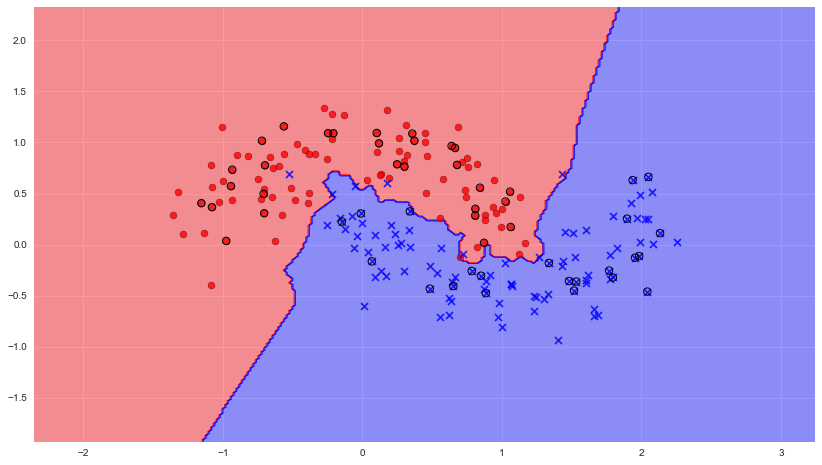

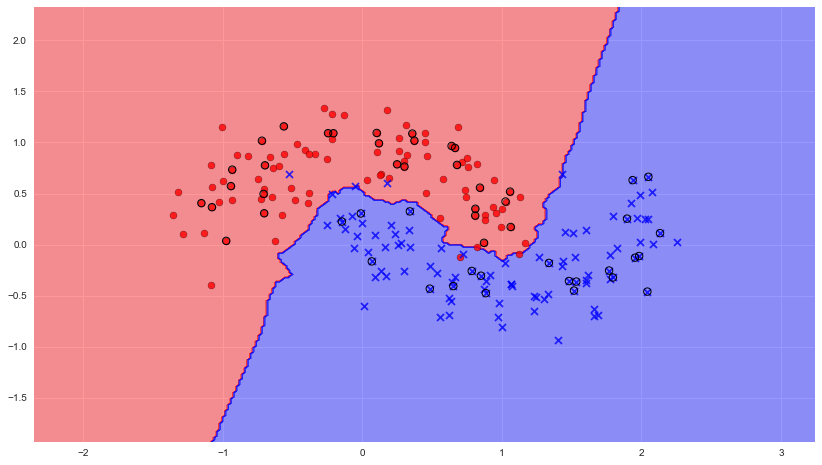

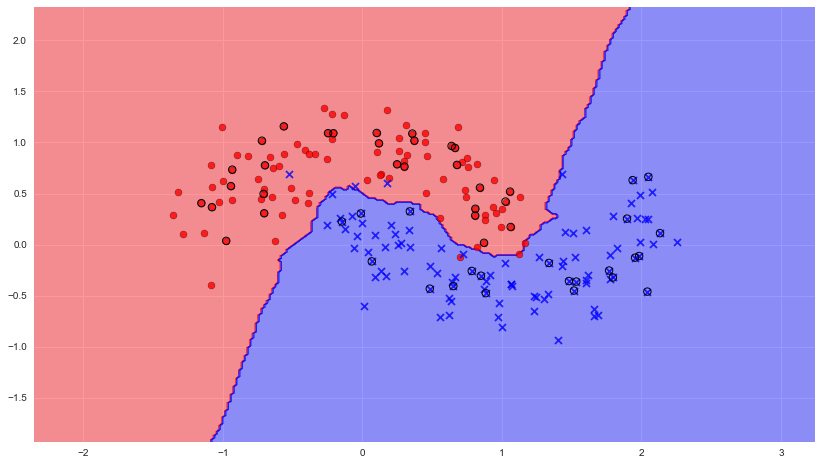

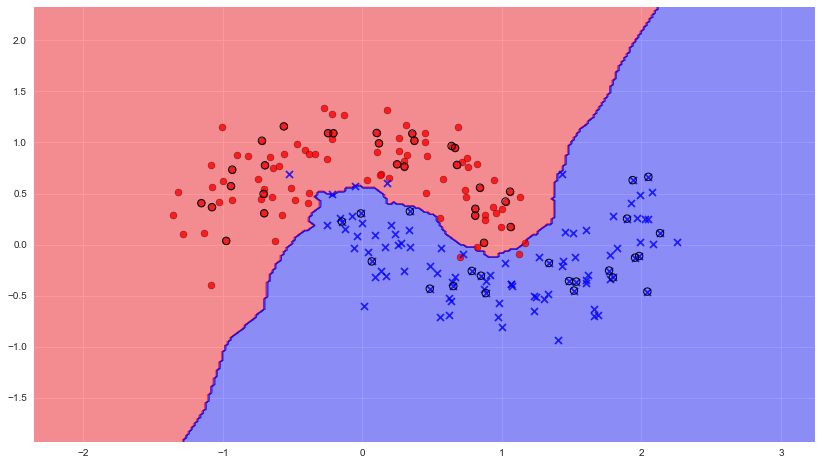

In [98]:
for k in range(1,10,2):
    clasificador = KNeighborsClassifier(n_neighbors=k)
    clasificador.fit(X4_entrenamiento, y4_entrenamiento)
    print(clasificador.score(X4_prueba, y4_prueba))
    plt.figure()
    graficar_regiones_decision(X, y, indices_prueba=indices, clasificador=clasificador)

### Graficar la regiones de decisión para el clasificador Árbol de Decisión.

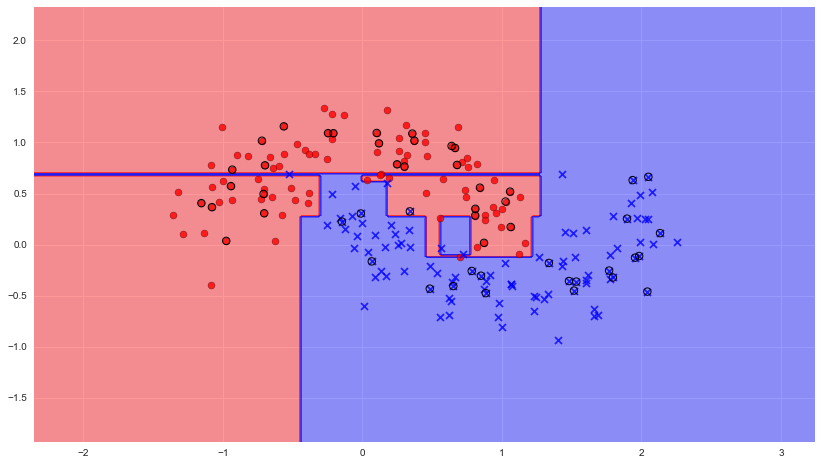

In [99]:
clasificador = DecisionTreeClassifier()
clasificador.fit(X4_entrenamiento, y4_entrenamiento)
plt.figure()
graficar_regiones_decision(X, y, indices_prueba=indices, clasificador=clasificador)

0.96


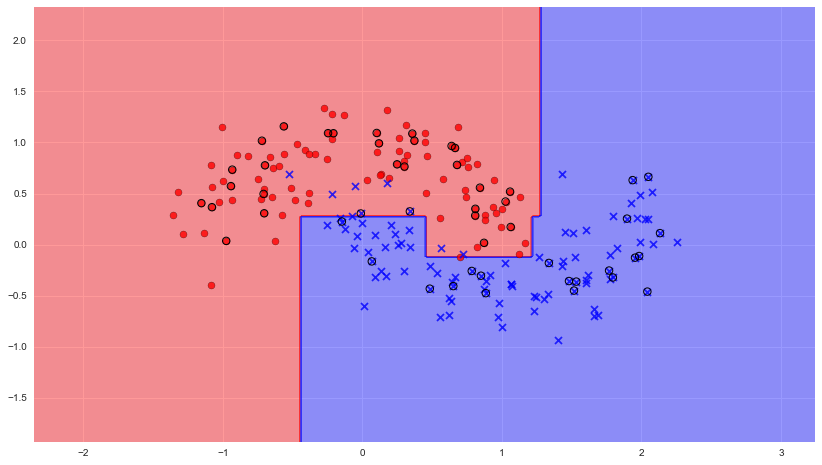

In [100]:
clasificador = DecisionTreeClassifier(min_samples_leaf=4)
clasificador.fit(X4_entrenamiento, y4_entrenamiento)
print(clasificador.score(X4_prueba, y4_prueba))
plt.figure()
graficar_regiones_decision(X, y, indices_prueba=indices, clasificador=clasificador)

### Graficar la regiones de decisión para el clasificador SVM.

/Users/wladimir/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.94


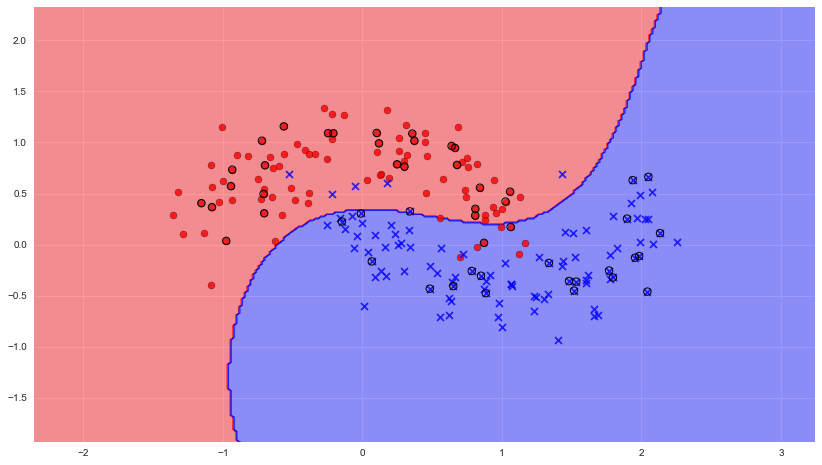

In [101]:
clasificador = SVC(kernel='rbf')
clasificador.fit(X4_entrenamiento, y4_entrenamiento)
print(clasificador.score(X4_prueba, y4_prueba))
plt.figure()
graficar_regiones_decision(X, y, indices_prueba=indices, clasificador=clasificador)

### Graficar las regiones de decisión para el clasificador Random Forrest

/Users/wladimir/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.98


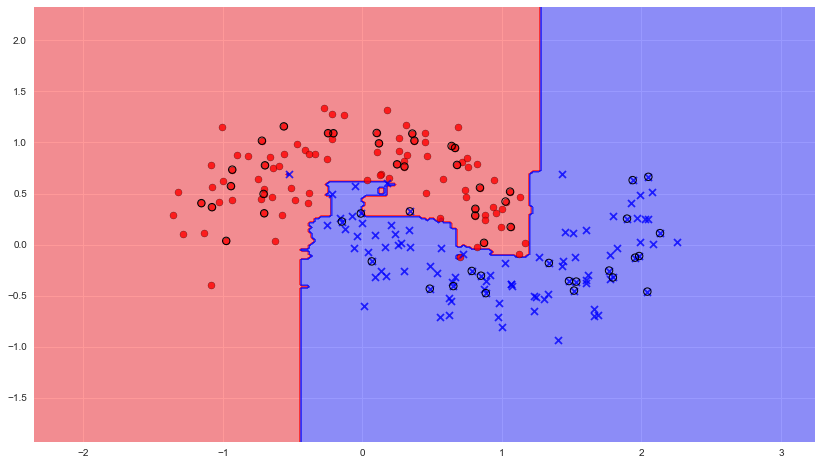

In [102]:
clasificador = RandomForestClassifier(criterion='entropy',n_estimators=100)
clasificador.fit(X4_entrenamiento, y4_entrenamiento)
print(clasificador.score(X4_prueba, y4_prueba))
plt.figure()
graficar_regiones_decision(X, y, indices_prueba=indices, clasificador=clasificador)

### Graficar las regiones de decisión para el clasificador AdaBoost

/Users/wladimir/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0


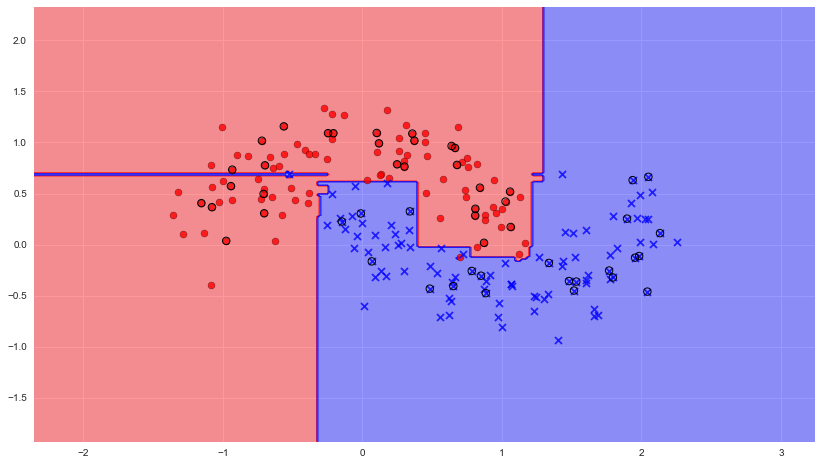

In [103]:
clasificador = AdaBoostClassifier(base_estimator=arbol, n_estimators=500, learning_rate=0.1, random_state=1)
clasificador.fit(X4_entrenamiento, y4_entrenamiento)
print(clasificador.score(X4_prueba, y4_prueba))
plt.figure()
graficar_regiones_decision(X, y, indices_prueba=indices, clasificador=clasificador)